The cross comparison method is proposed by Woz: https://supermemo.guru/wiki/Universal_metric_for_cross-comparison_of_spaced_repetition_algorithms#Algorithmic_contest:_SuperMemo_2_vs._SuperMemo_17

In [1]:
import pandas as pd
from pathlib import Path

dfs = []

for file in Path("./raw").glob("*.csv"):
    dfs.append(pd.read_csv(file))

df = pd.concat(dfs, ignore_index=True)
df.head()

,y,R (SM16),R (SM17),R (SM17(exp)),R (FSRSv3),R (FSRSv4),R (FSRS-4.5),R (FSRS-5),R (FSRS-6)
0,1,0.841,0.866,0.866,0.719585,0.545455,0.639610,0.603229,0.624
1,1,0.684,0.548,0.521,0.466960,0.344078,0.481360,0.447238,0.544
2,1,0.698,0.667,0.479,0.469736,0.348449,0.484324,0.450697,0.556
3,1,0.810,0.981,0.981,0.732465,0.503106,0.653706,0.621956,0.718
4,1,0.796,0.916,0.847,0.653506,0.492030,0.596322,0.561989,0.633


In [2]:
df.describe()

,y,R (SM16),R (SM17),R (SM17(exp)),R (FSRSv3),R (FSRSv4),R (FSRS-4.5),R (FSRS-5),R (FSRS-6)
count,194281.000000,194281.000000,194281.000000,194281.000000,1.942810e+05,194281.000000,194281.000000,194281.000000,194281.000000
mean,0.866904,0.853812,0.878373,0.861429,8.522668e-01,0.848275,0.848320,0.849279,0.856053
std,0.339679,0.157799,0.152628,0.155297,1.569044e-01,0.154655,0.150990,0.143837,0.112533
min,0.000000,0.005000,0.000000,0.001000,6.754230e-40,0.001122,0.009626,0.017989,0.104000
25%,1.000000,0.822000,0.812000,0.845000,8.166496e-01,0.796865,0.794467,0.790580,0.804000
50%,1.000000,0.912000,0.932000,0.900000,9.020244e-01,0.899398,0.896172,0.895380,0.882000
75%,1.000000,0.950000,0.995000,0.948000,9.524696e-01,0.954011,0.952276,0.952205,0.938000
max,1.000000,0.999000,1.000000,0.999000,9.999139e-01,0.999898,0.999884,0.999908,1.000000


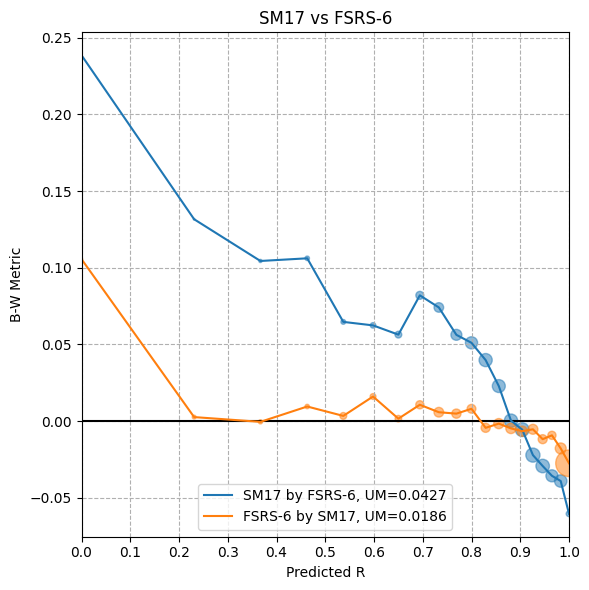

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import root_mean_squared_error


def cross_comparison(revlogs, algoA, algoB):
    cross_comparison_record = revlogs[[f"R ({algoA})", f"R ({algoB})", "y"]].copy()

    def get_bin(x, bins=20):
        return (np.log(np.exp(np.log(bins) * x).round()) / np.log(bins)).round(3)

    for algo in (algoA, algoB):
        cross_comparison_record[f"{algo}_B-W"] = (
            cross_comparison_record[f"R ({algo})"] - cross_comparison_record["y"]
        )
        cross_comparison_record[f"{algo}_bin"] = cross_comparison_record[
            f"R ({algo})"
        ].map(get_bin)

    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()
    ax.axhline(y=0.0, color="black", linestyle="-")

    for algoA, algoB in [(algoA, algoB), (algoB, algoA)]:
        cross_comparison_group = cross_comparison_record.groupby(by=f"{algoA}_bin").agg(
            {"y": ["mean"], f"{algoB}_B-W": ["mean"], f"R ({algoB})": ["mean", "count"]}
        )
        universal_metric = root_mean_squared_error(
            cross_comparison_group["y", "mean"],
            cross_comparison_group[f"R ({algoB})", "mean"],
            sample_weight=cross_comparison_group[f"R ({algoB})", "count"],
        )
        cross_comparison_group[f"R ({algoB})", "percent"] = (
            cross_comparison_group[f"R ({algoB})", "count"]
            / cross_comparison_group[f"R ({algoB})", "count"].sum()
        )
        ax.scatter(
            cross_comparison_group.index,
            cross_comparison_group[f"{algoB}_B-W", "mean"],
            s=cross_comparison_group[f"R ({algoB})", "percent"] * 1024,
            alpha=0.5,
        )
        ax.plot(
            cross_comparison_group[f"{algoB}_B-W", "mean"],
            label=f"{algoB} by {algoA}, UM={universal_metric:.4f}",
        )

    ax.legend(loc="lower center")
    ax.grid(linestyle="--")
    ax.set_title(f"{algoA} vs {algoB}")
    ax.set_xlabel("Predicted R")
    ax.set_ylabel("B-W Metric")
    ax.set_xlim(0, 1)
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    plt.tight_layout()
    plt.show()


cross_comparison(df, "FSRS-6", "SM17")

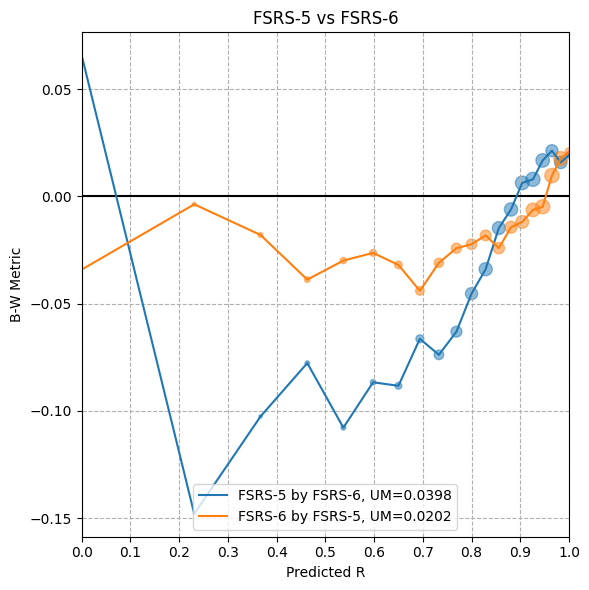

In [4]:
cross_comparison(df, "FSRS-6", "FSRS-5")

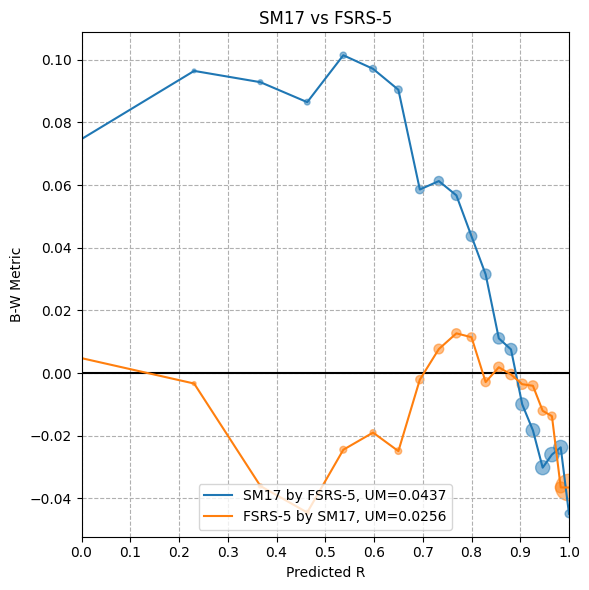

In [5]:
cross_comparison(df, "FSRS-5", "SM17")

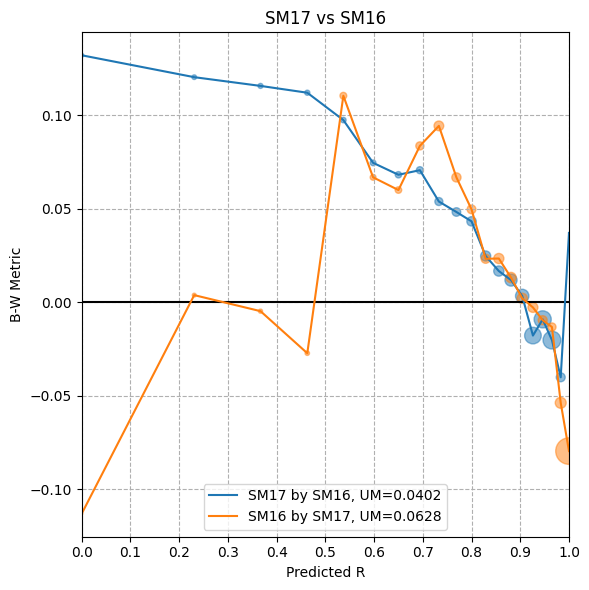

In [6]:
cross_comparison(df, "SM16", "SM17")